In [1]:
import numpy as np
import os
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import model
import evaluation
import preprocess
from collections import defaultdict
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
import warnings
import tuning


warnings.filterwarnings("ignore")
%matplotlib inline

dict_best_estimators, dict_best_params, dict_scores = tuning.load_tuning_result()
X, y = preprocess.load_data()
X_train, X_test, y_train, y_test = preprocess.load_train_test()
ensemble_params = dict_best_params.copy()
ensemble_params['DecisionTree']['splitter'] = 'random'
ensemble_params['DecisionTree']['max_depth'] = 5



# Proba

In [10]:
mds = []
model_num = {
    'DecisionTree': 15,
    'LR': 15,
    'SVM': 15,
    'XGBoost': 0
}
for md_name, md in tuning.models.items():
    params = ensemble_params[md_name]
    for i in range(model_num[md_name]):
        mds.append(md(**params))
       

**MLPEnsemble**

the recall for this model is : 0.874509803922


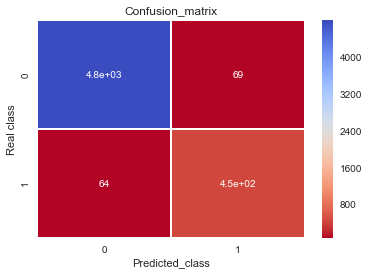


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4860
          1       0.87      0.87      0.87       510

avg / total       0.98      0.98      0.98      5370



Test Set Scores

{'test': {'f1': 0.87024390243902427, 'roc_auc': 0.97134148309529589},
 'train': {'f1': 0.88948069241011984, 'roc_auc': 0.97371989882101606}}

K-Fold Scores on Whole Data Set

mean([ 0.8741573   0.88888889  0.90052356])=0.8878565841563665

In [12]:
md = model.MLPEnsemble(learners=mds, layers=[15], activation='logistic')

display(Markdown("**MLPEnsemble**"))
scores = evaluation.estimate(
    md,
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
display(Markdown("Test Set Scores"))
display(scores)

display(Markdown("K-Fold Scores on Whole Data Set"))
cv_scores = evaluation.cross_validation(md, X, y)
display(Markdown("mean({})={}".format(cv_scores, cv_scores.mean())))

**Logistic Regression Ensemble (15 SVMs, 15 LRs, 15 DecisionTrees)**

the recall for this model is : 0.903921568627


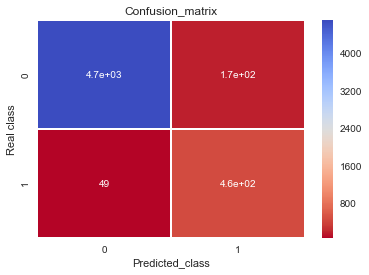


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      4860
          1       0.74      0.90      0.81       510

avg / total       0.97      0.96      0.96      5370



Test Set Scores

{'test': {'f1': 0.81090589270008806, 'roc_auc': 0.97343581053820705},
 'train': {'f1': 0.84008016032064137, 'roc_auc': 0.97611533527679584}}

K-Fold Scores on Whole Data Set

mean([ 0.83991684  0.85983067  0.83394834])=0.8445652824404043

In [22]:
mds = []
model_num = {
    'DecisionTree': 15,
    'LR': 15,
    'SVM': 15,
    'XGBoost': 0
}

for md_name, md in tuning.models.items():
    params = ensemble_params[md_name]
    for i in range(model_num[md_name]):
        mds.append(md(**params))
       
md = model.LinearEnsemble(learners=mds)

display(Markdown("**Logistic Regression Ensemble (15 SVMs, 15 LRs, 15 DecisionTrees)**"))
scores = evaluation.estimate(
    md,
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
display(Markdown("Test Set Scores"))
display(scores)

display(Markdown("K-Fold Scores on Whole Data Set"))
cv_scores = evaluation.cross_validation(md, X, y)
display(Markdown("mean({})={}".format(cv_scores, cv_scores.mean())))

**Logistic Regression Ensemble (1 SVM, 1 LR, 1 DecisionTree)**

the recall for this model is : 0.909803921569


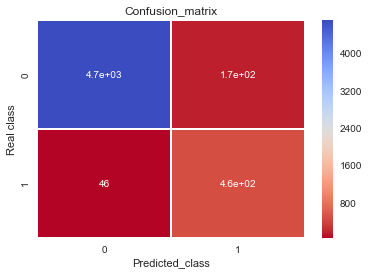


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      4860
          1       0.73      0.91      0.81       510

avg / total       0.97      0.96      0.96      5370



Test Set Scores

{'test': {'f1': 0.81118881118881114, 'roc_auc': 0.97524449285887205},
 'train': {'f1': 0.8385291766586731, 'roc_auc': 0.97648046294987589}}

K-Fold Scores on Whole Data Set

mean([ 0.84243697  0.87047619  0.84882629])=0.8539131521153062

In [21]:
mds = []
model_num = {
    'DecisionTree': 1,
    'LR': 1,
    'SVM': 1,
    'XGBoost': 0
}
for md_name, md in tuning.models.items():
    params = ensemble_params[md_name]
    for i in range(model_num[md_name]):
        mds.append(md(**params))
       
    
md = model.LinearEnsemble(learners=mds, random)

display(Markdown("**Logistic Regression Ensemble (1 SVM, 1 LR, 1 DecisionTree)**"))
scores = evaluation.estimate(
    md,
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
display(Markdown("Test Set Scores"))
display(scores)

display(Markdown("K-Fold Scores on Whole Data Set"))
cv_scores = evaluation.cross_validation(md, X, y)
display(Markdown("mean({})={}".format(cv_scores, cv_scores.mean())))

# Stacked

**Stacked Ensemble (SVM with 3 LR to Filter)**

the recall for this model is : 0.864705882353


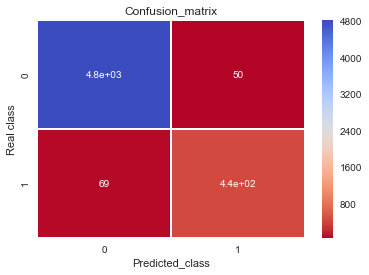


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4860
          1       0.90      0.86      0.88       510

avg / total       0.98      0.98      0.98      5370



Test Set Scores

{'test': {'f1': 0.88111888111888126, 'roc_auc': 0.84456205115791183},
 'train': {'f1': 0.89080982711555956, 'roc_auc': 0.85345854542117539}}

K-Fold Scores on Whole Data Set

mean([ 0.88290398  0.89119171  0.90276356])=0.8922864176778181

Average ratio of filtered samples = 0.669860

In [3]:
stacked =  [
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
] 
md = model.StackedEnsembleModel(learners=stacked, next_model=model.SVM(**dict_best_params['SVM']), min_recall=0.99)

display(Markdown("**Stacked Ensemble (SVM with 3 LR to Filter)**"))
scores = evaluation.estimate(
    md,
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
display(Markdown("Test Set Scores"))
display(scores)

display(Markdown("K-Fold Scores on Whole Data Set"))
cv_scores = evaluation.cross_validation(md, X, y)
display(Markdown("mean({})={}".format(cv_scores, cv_scores.mean())))

filter_rate = np.mean(md.filter_rate_['predict'])
display(Markdown("Average ratio of filtered samples = %f" % (filter_rate, )))

**Stacked Ensemble (XGBoost with 3 LR to Filter)**

the recall for this model is : 0.852941176471


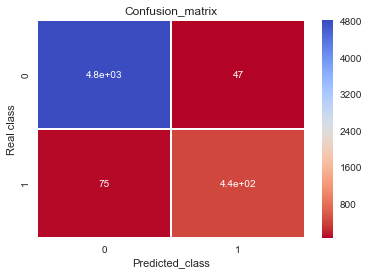


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      4860
          1       0.90      0.85      0.88       510

avg / total       0.98      0.98      0.98      5370



Test Set Scores

{'test': {'f1': 0.87701612903225801, 'roc_auc': 0.84493201807471963},
 'train': {'f1': 0.9810469314079423, 'roc_auc': 0.85300157248110664}}

K-Fold Scores on Whole Data Set

mean([ 0.87383178  0.88445378  0.8994709 ])=0.8859188188948129

Average ratio of filtered samples = 0.669860

In [9]:
stacked =  [
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
] 
com_model = model.XGBoost(**dict_best_params['XGBoost'])
md = model.StackedEnsembleModel(learners=stacked, next_model=com_model, min_recall=0.99)

display(Markdown("**Stacked Ensemble (XGBoost with 3 LR to Filter)**"))
scores = evaluation.estimate(
    md,
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
display(Markdown("Test Set Scores"))
display(scores)

display(Markdown("K-Fold Scores on Whole Data Set"))
cv_scores = evaluation.cross_validation(md, X, y)
display(Markdown("mean({})={}".format(cv_scores, cv_scores.mean())))

filter_rate = np.mean(md.filter_rate_['predict'])
display(Markdown("Average ratio of filtered samples = %f" % (filter_rate, )))

**Stacked Ensemble (Decision Tree with 3 LR to Filter)**

(Max depth of decision tree is set to 4)

the recall for this model is : 0.850980392157


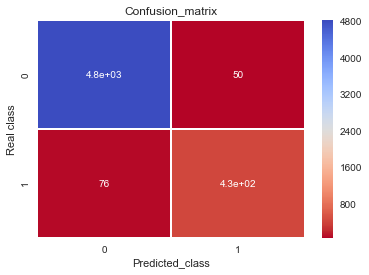


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      4860
          1       0.90      0.85      0.87       510

avg / total       0.98      0.98      0.98      5370



Test Set Scores

{'test': {'f1': 0.87323943661971826, 'roc_auc': 0.84347696280158158},
 'train': {'f1': 0.90287277701778379, 'roc_auc': 0.85332035015269847}}

K-Fold Scores on Whole Data Set

mean([ 0.8783314   0.88410256  0.84180791])=0.8680806252642772

Average ratio of filtered samples = 0.669860

In [7]:
stacked =  [
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
] 
com_model = model.DecisionTree(max_depth=4)
md = model.StackedEnsembleModel(learners=stacked, next_model=com_model, min_recall=0.99)

display(Markdown("**Stacked Ensemble (Decision Tree with 3 LR to Filter)**"))
display(Markdown("(Max depth of decision tree is set to 4)"))
scores = evaluation.estimate(
    md,
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
display(Markdown("Test Set Scores"))
display(scores)

display(Markdown("K-Fold Scores on Whole Data Set"))
cv_scores = evaluation.cross_validation(md, X, y)
display(Markdown("mean({})={}".format(cv_scores, cv_scores.mean())))

filter_rate = np.mean(md.filter_rate_['predict'])
display(Markdown("Average ratio of filtered samples = %f" % (filter_rate, )))

**Stacked Ensemble with min_neg_recall(SVM with 3 LR to Filter)**

the recall for this model is : 0.8666666666666667


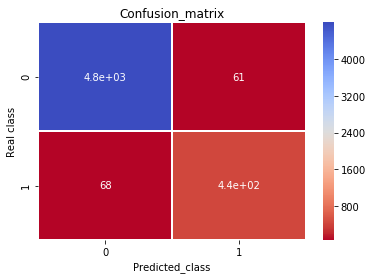


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4860
          1       0.88      0.87      0.87       510

avg / total       0.98      0.98      0.98      5370



Test Set Scores

{'test': {'f1': 0.8726554787759132, 'roc_auc': 0.9714268135237635},
 'train': {'f1': 0.8917826672653795, 'roc_auc': 0.9721189006137082}}

K-Fold Scores on Whole Data Set

mean([0.87878788 0.88730964 0.90184049])=0.8893126714184918

Average ratio of filtered samples = 0.680103

In [4]:
stacked =  [
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
    model.LinearModel(**dict_best_params['LR']), 
] 
md = model.StackedEnsembleModel(learners=stacked, 
                                next_model=model.SVM(**dict_best_params['SVM']), 
                                min_recall=0.99, min_neg_recall=0.95)

display(Markdown("**Stacked Ensemble with min_neg_recall(SVM with 3 LR to Filter)**"))
scores = evaluation.estimate(
    md,
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
display(Markdown("Test Set Scores"))
display(scores)

display(Markdown("K-Fold Scores on Whole Data Set"))
cv_scores = evaluation.cross_validation(md, X, y)
display(Markdown("mean({})={}".format(cv_scores, cv_scores.mean())))

filter_rate = np.mean(md.filter_rate_['predict'])
display(Markdown("Average ratio of filtered samples = %f" % (filter_rate, )))